In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
np.random.seed(1001)

In this notebook I want to showcase the use of Eigenvalues and Eigenvectors for non-linear optimization problems. In this particular example we use them to find an optimal rotation and translation in two dimensions.
 
A common task in robotics is to find spatial transformations $R_i,p_i$ in a way, such that some points $x_{k}$ align to a plane as well as possible. Classically this would be done by estimating the planes parameters, given as normals $n_j$ and distances $d_j$ from the origin, along with the transformation parameters. Then for each point one would compute the point to plane residual $n_j \cdot (R_i x_i + p_k) - d_j$, using those to find the best parameters through least squares optimization. Given $N_{Pose}$ poses and $N_{Plane}$ planes the optimization objective would therefore look like:

$$
\begin{align*}
L(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}, n_1, d_1, ..., n_{N_{Plane}}, d_{N_{Plane}}) = \frac{1}{2}\sum_{i=1}^{N_{Pose}}\sum_{j=1}^{N_{Plane}}\sum_{k=1}^{N_{i, j}}(n_j \cdot (R_i x_k + p_i) - d_j)^2
\end{align*}
$$

where $N_{i, j}$ is the amount of points on plane $i$ coming from pose $j$. However the more planes one has to fit the points on, the more parameters one has to optimize over. A plane can be decribed as a normal vector and a distance from the coordinate systems origin, meaning that for each plane one has to estimate additional 4 parameters. This can go out of hands pretty quickly for multiple planes.

Now, by using the eigenvalues and eigenvectors one can get rid of this issue, while still precisely finding the optimal solution to the stated problem. What is here described with a plane and points in 3D, will now for simplicity be demonstarted with a line and points in 2D. As long as one wants to flatten data points to a hyperplane, the optimization through eigenvalues and eigenvectors offers a very elegant method to do so in any dimension.

First we will define a function that outputs for an input vector v of shape $(3)$ a rotation and translation with shapes $(2, 2)$ and $(2, 1)$. The first two values of v thereby correspond to the x and y translation values, the last entry of v to the rotation angle. If derivative is set to True, the jacobians of the rotation and translation with respect to v are output as well (where the first axis corresponds to v, so the outputs are of shape $(3, 2, 2)$ and $(3, 2, 1)$).

In [17]:
def transformation(v, derivative=False):
    x, y, a = v  # x, y translation; rotation angle a
    
    R = np.array([[np.cos(a), -np.sin(a)],
                  [np.sin(a),  np.cos(a)]])
    p = np.array([[x],
                  [y]])
    
    if derivative:
        d_R = np.array([[[0, 0],
                         [0, 0]],
                        [[0, 0],
                         [0, 0]],
                        [[-np.sin(a), -np.cos(a)],
                         [ np.cos(a), -np.sin(a)]]]).reshape(3, 1, 1, 1, 2, 2)
        d_p = np.array([[[1],
                         [0]],
                        [[0],
                         [1]],
                        [[0],
                         [0]]]).reshape(3, 1, 1, 1, 2, 1)
        
        return R, p, d_R, d_p
    
    else:
        return R, p

Now lets create some sample data. In particular we here want to create some points along lines.

In [18]:
n_lines = 3
n_points_per_line = 25

# create some almost linear points along the x-axis
points = np.random.randn(1, 1, n_points_per_line, 2, 1) * np.array([3e-1, 1e-2]).reshape(2, 1)

# create some variations of this line by rotating and translating it
for i in range(n_lines - 1):
    v = np.random.randn(3)
    R, p = transformation(v)
    
    points = np.append(points, R @ points[[0], ...] + p, axis=0)

The shape will be of the form $(N_{lines}, 1, N_{points \text{ } per \text{ } line}, 2, 1)$, so we have $N_{lines}$ by $N_{points \text{ } per \text{ } line}$ points with two x and y coordinates each (seen as $(2, 1)$ vectors). The reason for the 1 at the second axis will become clear soon.

Lets look at the data

Data shape: (3, 1, 25, 2, 1)


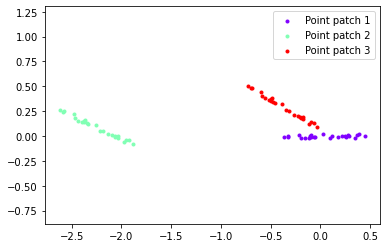

In [19]:
print(f"Data shape: {points.shape}")

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    plt.scatter(points[i, :, :, 0, 0], points[i,:, :, 1, 0], 
                color=colors[i, :], marker='.', label=f"Point patch {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

We now assume this data is altered by a rotation and translation, specified by v below.


In [20]:
v = np.array([0.5, 1, 2]) # x-translation, y-translation, rotation angle

R, p = transformation(v)
points = np.concatenate([points, R @ points + p], axis=1)

# Lets also add some noise to those transformed points
noise_level = 1e-2
points[:, 1, :, :, :] += np.random.randn(n_lines, n_points_per_line, 2, 1) * noise_level

We now see the use of the second axis, all our points are neatly vectorized. The unaltered and altered points are specified at exactly this axis.

Let us take a second look at the data, the altered points are shown by the x-marker. We can see how the two line sets, marked by dots and crosses, differ by a rotation and translation.

New data shape: (3, 2, 25, 2, 1)


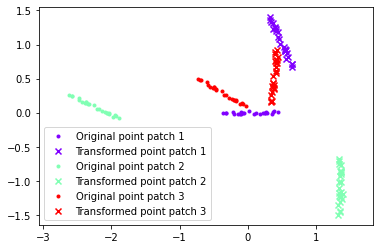

In [21]:
print(f"New data shape: {points.shape}")

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points[i, j, :, 0, 0], points[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Original" if j == 0 else "Transformed") + f" point patch {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

We further define a function computing for each pair of lines (the original and transformed one) its smallest eigenvalue and corresponding eigenvector. That is, for each such line we do a Principal Component Analysis by computing the covariance matrix of the underlying points. A finer explanation will be given in the next cell.

In [22]:
def eigen(v, derivative=False):
    if derivative:
        R, p, d_R, d_p = transformation(v, derivative=True)
        R = np.stack([R, np.eye(2)]).reshape(1, 2, 1, 2, 2)
        p = np.stack([p, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
        d_R = np.concatenate([d_R, np.zeros((3, 1, 1, 1, 2, 2))], axis=2)
        d_p = np.concatenate([d_p, np.zeros((3, 1, 1, 1, 2, 1))], axis=2)

        points_ = (R @ points + p).reshape(n_lines, -1, 2, 1)
        d_points_ = (d_R @ points + d_p).reshape(3, n_lines, -1, 2, 1)
        
        mu = np.mean(points_, axis=-3)
        d_mu = np.mean(d_points_, axis=-3)
        S = np.mean(points_ @ np.swapaxes(points_, -1, -2), axis=-3) - \
            mu @ np.swapaxes(mu, -1, -2)
        d_S = np.mean(d_points_ @ np.swapaxes(points_, -1, -2), axis=-3) + \
              np.mean(points_ @ np.swapaxes(d_points_, -1, -2), axis=-3) - \
              d_mu @ np.swapaxes(mu, -1, -2) - \
              mu @ np.swapaxes(d_mu, -1, -2)

        w, v = np.linalg.eigh(S)
        w, v = w[:, [0], None], v[:, :, [0]]

        d_w = (np.swapaxes(v, -1, -2) @ d_S @ v)
        d_v = np.linalg.pinv(w * np.eye(2) - S) @ d_S @ v
        
        return w, v, d_w, d_v
    
    else:
        R, p = transformation(v, derivative=False)
        R = np.stack([R, np.eye(2)]).reshape(1, 2, 1, 2, 2)
        p = np.stack([p, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
        
        points_ = (R @ points + p).reshape(n_lines, -1, 2, 1)
        
        mu = np.mean(points_, axis=-3)
        S = np.mean(points_ @ np.swapaxes(points_, -1, -2), axis=-3) - \
            mu @ np.swapaxes(mu, -1, -2)

        w, v = np.linalg.eigh(S)
        w, v = w[:, [0], None], v[:, :, [0]]

        return w, v

The ultimate task of this notebook is to estimate the previously specified transformation parameters (the v array from before) soley by looking at the data. That is we want to answer the question about how can we move the dotted points in the image above, such that they align well with the crossed ones.

The optimal solution therefore should look like this. The two point sets overlap each other well.

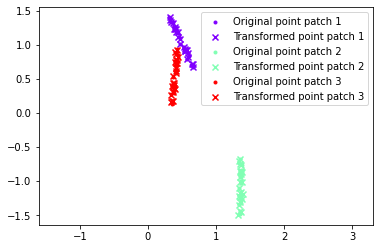

In [23]:
R, p = transformation(v)
points_ = points.copy()
points_[:, 0, :, :, :] = R @ points_[:, 0, :, :, :] + p

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points_[i, j, :, 0, 0], points_[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Original" if j == 0 else "Transformed") + f" point patch {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

In particular we want to achive this task, finding v, by looking at eigenvalues and eigenvectors. What exactly do we mean here? Let's consider an example and let look at another set of 2D datapoints first. We create those example points by sampling them from a gaussian distribution. To do so, we define the covariance and the mean of the distribution and then sample from it.

In [24]:
cov = np.array([[2.0, 0.4], [0.4, 0.2]])
mean = np.array([1, 2])

data = np.random.multivariate_normal(mean, cov, size=(100))

Let us have a look at the sampled points.


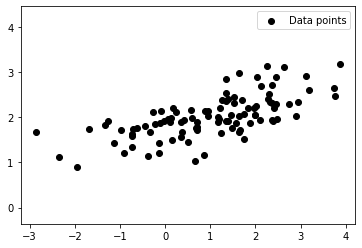

In [25]:
plt.scatter(data[:, 0], data[:, 1], c='k', label="Data points")
plt.axis('equal')
plt.legend()
plt.show()

We can see a linear shape within these data points. This can also be observed through the covariance matrix underlying them. If we compute the eigenvalues of eigenvectors and plot them on the data we can observe how their direction and spread dictates the form it.

That is, the eigenvectors give us the directions along which the data is spread out, while the magnitute of that spread is given by the corresponding eigenvalue. Now if we want to observe how linear some datapoints are, we can therefore look at the eigenvalues. The smaller the smallest of the two eigenvalues is (while the other one is big), the more linear our points are. In our example the two eigenvalues are:

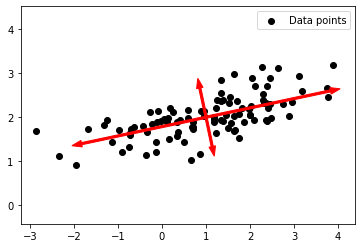

The eigenvalues: [0.11511422 2.08488578]


In [26]:
eigenvalues, eigenvectors = np.linalg.eigh(cov)

plt.scatter(data[:, 0], data[:, 1], c='k', label="Data points")
plt.arrow(mean[0], mean[1], 
          eigenvectors[0, 0] * 2 * np.sqrt(eigenvalues[0]), 
          eigenvectors[1, 0] * 2 * np.sqrt(eigenvalues[0]),
         color='r', width=0.05)
plt.arrow(mean[0], mean[1], 
          -eigenvectors[0, 0] * 2 * np.sqrt(eigenvalues[0]), 
          -eigenvectors[1, 0] * 2 * np.sqrt(eigenvalues[0]),
         color='r', width=0.05)
plt.arrow(mean[0], mean[1], 
          eigenvectors[0, 1] * 2 * np.sqrt(eigenvalues[1]), 
          eigenvectors[1, 1] * 2 * np.sqrt(eigenvalues[1]),
         color='r', width=0.05)
plt.arrow(mean[0], mean[1], 
          -eigenvectors[0, 1] * 2 * np.sqrt(eigenvalues[1]), 
          -eigenvectors[1, 1] * 2 * np.sqrt(eigenvalues[1]),
         color='r', width=0.05)
plt.axis('equal')
plt.legend()
plt.show()

print(f"The eigenvalues: {eigenvalues}")

In praxis we will not know the underlying covariance matrix describing some data points shape, as we are only given the data points themselves. However from them we can directly compute the covariance matrix ourselves. That is exactly what we defined our eigen function for. It computes for our line tuples at first the covariance matrix and consequently there the eigenvalues and eigenvectors (potentially together with the jacobians respective the transformation parameters v).

With this theory in mind, lets look at the eigenvalues of our previous sample lines above. If the two point sets are well aligned, that is, we know the optimal transformation v, all of our lines have a very small smallest eigenvalue. This makes sense since they are almost linear, as can be seen in the image above.

In [28]:
eigenvalues, eigenvectors = eigen(v)
print(f"Eigenvalues: {eigenvalues.reshape(-1)}")

Eigenvalues: [0.00015357 0.00018076 0.00015909]


If instead we take the unaligned lines, that is, we compute the the eigenvalues of our line tuples while they are far apart, we can see how their eigenvalues are bigger. This makes sense, as here our line tuples aren't actually lines at all, but (close to) randomly scattered points in space.

In [29]:
eigenvalues, eigenvectors = eigen(np.array([0, 0, 0]))
print(f"Eigenvalues: {eigenvalues.reshape(-1)}")

Eigenvalues: [0.0398517  0.02715278 0.03966742]


So if we want to find the optimal values for v we can look at the eigenvalues of the line point tuples. If we manage to gradually decraese them we will be able to find the desired values. This sounds like an optimization problem! If we define the function computing the smallest eigenvalue for each of the planes point sets, given the spatial transfromations $R_i,p_i$, as $E_j(R_1, p_1, ...,R_{N_{Pose}},p_{N_{Pose}})$, the optimimization objective is now reduced to

$$
\begin{align*}
L(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}) = \sum_{j=1}^{N_{Plane}}E_j(R_1, p_1, ...,R_{N_{Pose}},p_{N_{Pose}})
\end{align*}
$$

And indeed, if we take each of the lines eigenvalues as a residual we can find the solution through classical least squares optimization. Now in theory the eigenvalues aren't fully differentiable. In fact we get singularities for the cases where the smallest eigenvalue for a point set cannot uniquely be determined. However this means that if we start close enough to the actual solution, and our eigenvalues stay unique throughout the whole process, we are well off.

So lets try it out! We define our loss functions, the derivative function as well as our initial guess. We observe that we can find the optimal solution very precisely (remember that we also added in noise before). However we see that we needed a lot of iterations to find it. We proved that eigenvalues can in fact be used for finding optimal transformations. Now we only need to make it work quicker.

In [30]:
def f(x):
    w, v = eigen(x, derivative=False)
    return w.reshape(-1)
    
def jac_f(x):
    w, v, d_w, d_v = eigen(x, derivative=True)
    return d_w.reshape(3, -1).T

x_0 = np.array([0, 0, 0])
res = least_squares(f, x_0, jac_f, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9495e-03                                    5.19e-03    
       1              2         1.3321e-03      6.17e-04       1.23e+00       2.53e-03    
       2              3         1.0228e-03      3.09e-04       1.01e+00       1.60e-03    
       3              4         2.6088e-04      7.62e-04       1.07e+00       1.35e-03    
       4              5         4.0474e-05      2.20e-04       9.18e-01       3.33e-04    
       5              6         2.0306e-05      2.02e-05       2.01e+00       3.29e-04    
       6              7         1.0324e-06      1.93e-05       6.19e-01       1.39e-04    
       7              8         9.9522e-08      9.33e-07       4.16e-02       1.26e-05    
       8             10         9.1312e-08      8.21e-09       9.84e-02       1.01e-05    
       9             11         4.6281e-08      4.50e-08       2.50e-02       6.66e-07    

Let us verify that solution

Optimal solution:  [0.50023417 1.0032277  1.99883729]


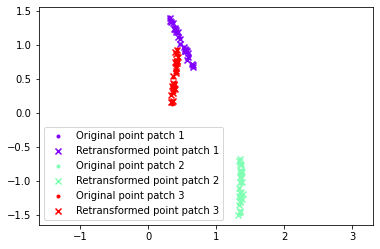

In [31]:
print('Optimal solution: ', res.x)

R, p = transformation(res.x, derivative=False)
points_ = points.copy()
points_[:, 0, :, :, :] = R @ points_[:, 0, :, :, :] + p

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points_[i, j, :, 0, 0], points_[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Original" if j == 0 else "Retransformed") + f" point patch {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

Instead of taking the eigenvalues as residuals we can also compute the point to line distance, as it would be done classically in theese kind of problems. However as opposed to those, with our method we do not need to estimate the lines properties through extra parameters. Remebering from what we explained before, we actually get the description of each line through the eigenvector corresponding to the smallest eigenvalue. So as in the beginning the optimization objective is now again

$$
\begin{align*}
L(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}) = \frac{1}{2}\sum_{i=1}^{N_{Pose}}\sum_{j=1}^{N_{Plane}}\sum_{k=1}^{N_{i, j}}(n_j(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}) \cdot (R_i x_k + p_i) - d_j(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}))^2
\end{align*}
$$

where however $d_j$ and $n_j$ are now functions of the to the plane corresponding points and the respective spatial transformations $R_i, p_i$. So instead we can take as residuals the distance of each point to the line computed through the eigendecomposition, that is instead of only estimating the transformation parameters we estimate the lines properties as well. Only now without the need of any extra parameters, but soley by looking at the covariance matrix of our data points. Trying it out, we indeed see a great improvement in speed.



In [32]:
def f(x):
    w, v = eigen(x, derivative=False)
    
    R, p = transformation(x, derivative=False)
    R = np.stack([R, np.eye(2)]).reshape(1, 2, 1, 2, 2)
    p = np.stack([p, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
        
    points_ = (R @ points + p).reshape(n_lines, -1, 2, 1)
        
    mu = np.mean(points_, axis=-3, keepdims=True)
    distances = np.swapaxes(v.reshape(-1, 1, 2, 1), -1, -2) @ (points_ - mu)

    return distances.reshape(-1)
    
def jac_f(x):
    w, v, d_w, d_v = eigen(x, derivative=True)
    
    R, p, d_R, d_p = transformation(x, derivative=True)
    R = np.stack([R, np.eye(2)]).reshape(1, 2, 1, 2, 2)
    p = np.stack([p, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
    d_R = np.concatenate([d_R, np.zeros((3, 1, 1, 1, 2, 2))], axis=2)
    d_p = np.concatenate([d_p, np.zeros((3, 1, 1, 1, 2, 1))], axis=2)

    points_ = (R @ points + p).reshape(n_lines, -1, 2, 1)
    d_points_ = (d_R @ points + d_p).reshape(3, n_lines, -1, 2, 1)
        
    mu = np.mean(points_, axis=-3, keepdims=True)
    d_mu = np.mean(d_points_, axis=-3, keepdims=True)
    
    distances = np.swapaxes(d_v.reshape(3, -1, 1, 2, 1), -1, -2) @ (points_ - mu) + \
                np.swapaxes(v.reshape(-1, 1, 2, 1), -1, -2) @ (d_points_ - d_mu)
    
    return distances.reshape(3, -1).T

x_0 = np.array([0, 0, 0])
res = least_squares(f, x_0, jac_f, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6668e+00                                    3.10e+00    
       1              2         1.5695e+00      1.10e+00       1.15e+00       3.44e+00    
       2              3         4.0126e-01      1.17e+00       7.34e-01       1.72e+00    
       3              4         1.7409e-01      2.27e-01       4.13e-01       1.56e+00    
       4              5         3.8270e-02      1.36e-01       7.43e-01       1.34e+00    
       5              6         1.2680e-02      2.56e-02       1.11e-01       5.07e-01    
       6              7         1.2278e-02      4.02e-04       1.76e-02       2.18e-03    
       7              8         1.2278e-02      5.65e-09       3.43e-05       4.30e-08    
       8              9         1.2278e-02      3.99e-17       3.69e-09       1.13e-11    
`gtol` termination condition is satisfied.
Function evaluations 9, initial cost 2.6668e+00

We can confirm that this solution is again correct.

Optimal solution:  [0.49998324 1.00429842 1.99897692]


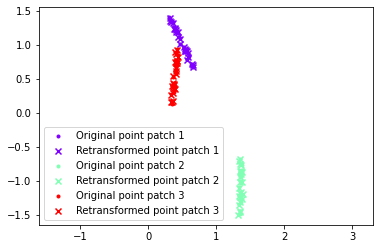

In [33]:
print('Optimal solution: ', res.x)

R, p = transformation(res.x, derivative=False)
points_ = points.copy()
points_[:, 0, :, :, :] = R @ points_[:, 0, :, :, :] + p

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points_[i, j, :, 0, 0], points_[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Original" if j == 0 else "Retransformed") + f" point patch {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()